# Задание 3. Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
D = np.loadtxt('lin_reg.txt', delimiter=',')
X = D[:, :-1]
y = D[:, -1].reshape(-1, 1)

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [191]:
class LinearRegression:

    def __init__(self, max_iter=1e3, lr=0.001, tol=0.01, l2_coef=1.):

        self.max_iter = max_iter
        self.lr = lr
        self.tol = tol
        self.l2_coef = l2_coef
        self.weights = None
        self.bias = None
        self.loss_history = []

    def fit(self, X_train, y_train):

        n, m = X_train.shape

        self.weights = np.zeros((m, 1))
        self.bias = np.mean(y_train)

        n_iter = 0
        gradient_norm = np.inf

        while n_iter < self.max_iter and gradient_norm > self.tol:
            
            iter_loss = ((self.predict(X_train) - y_train)**2).sum() / (2*n) + \
                        0.5 * self.l2_coef * (self.weights**2).sum()
            
            self.loss_history.append(iter_loss)
            
            dJdw, dJdb = self.grads(X_train, y_train)

            gradient_norm = np.linalg.norm(np.hstack([dJdw.flatten(), [dJdb]]))

            self.weights = self.weights - self.lr * dJdw
            self.bias = self.bias - self.lr * dJdb

            n_iter += 1

        return self

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

    def grads(self, X, y):

        y_hat = self.predict(X)
        
        dJdw = np.mean(X * (y_hat - y), axis=0, keepdims=True).T + self.l2_coef * self.weights
        dJdb = np.mean(y_hat - y)

        return dJdw, dJdb 

In [142]:
X_train, X_test = X[:750], X[750:]
y_train, y_test = y[:750], y[750:]

In [143]:
X_train.shape, y_train.shape

((750, 4), (750, 1))

In [42]:
y_train.mean(), y_train.min(), y_train.max()

(1.9575253333333331, -253.306, 258.332)

In [43]:
y_test.mean(), y_test.min(), y_test.max()

(4.434303999999999, -271.322, 248.672)

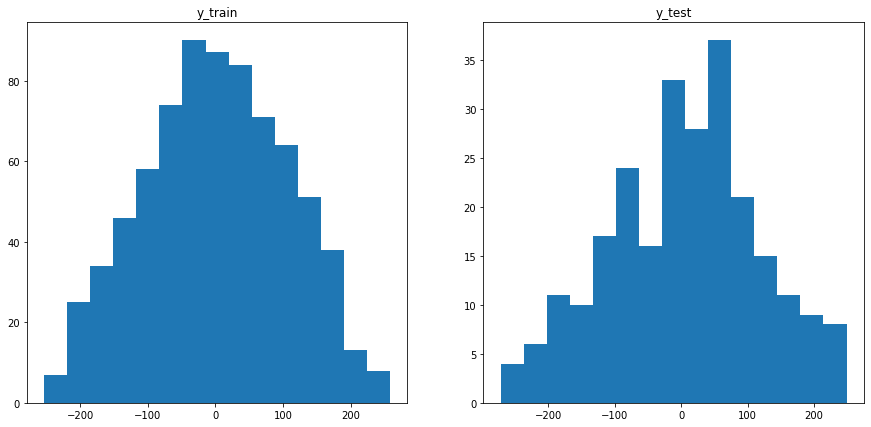

In [44]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(7)
fig.set_figwidth(15)

ax1.hist(y_train, bins=15)
ax1.set_title('y_train')

ax2.hist(y_test, bins=15)
ax2.set_title('y_test')

plt.show()

In [45]:
model = LinearRegression()

In [46]:
model.fit(X_train, y_train)

In [47]:
def MSE(y_true, y_pred):
    
    return ((y_true - y_pred)**2).mean()

In [48]:
y_pred = model.predict(X_test)

In [49]:
MSE(y_test, y_pred)

104.86768481010081

In [50]:
errors = []
l2_coef_grid = np.arange(0.01, 0.1, 0.01)

for l2_coef in l2_coef_grid:
    
    model = LinearRegression(l2_coef=l2_coef)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    errors.append(MSE(y_test, y_pred))

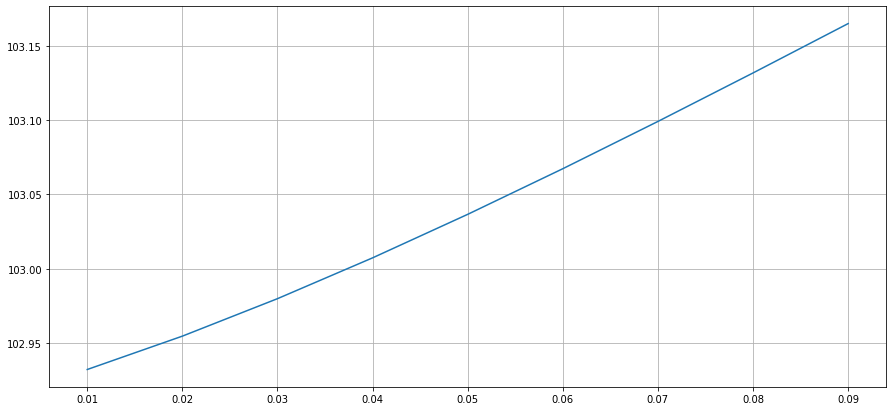

In [51]:
plt.figure(figsize=(15, 7))
plt.plot(l2_coef_grid, errors)
plt.grid()
plt.show()

In [172]:
def cv_split(X, y, n_folds=5):
    
    fold_size = X.shape[0] // n_folds
    start_idx = 0
    
    for i in range(n_folds):
        
        X_train = np.delete(X, range(start_idx, start_idx + fold_size), 0)
        y_train = np.delete(y, range(start_idx, start_idx + fold_size), 0)
        
        X_val = X[start_idx:start_idx + fold_size]
        y_val = y[start_idx:start_idx + fold_size]
        
        start_idx += fold_size
        
        yield X_train, X_val, y_train, y_val

In [193]:
l2_coef_grid = np.arange(0.01, 0.1, 0.01)

best_l2 = -1
best_score = np.inf 

val_scores = []
train_scores = []

for l2_coef in l2_coef_grid:
    
    val_fold_scores = []
    train_fold_scores = []
    
    for X_train_cv, X_val_cv, y_train_cv, y_val_cv in cv_split(X_train, y_train):
    
        model = LinearRegression(l2_coef=l2_coef)
        model.fit(X_train_cv, y_train_cv)
        
        y_pred_val = model.predict(X_val_cv)
        y_pred_train = model.predict(X_train_cv)
        
        val_fold_scores.append(MSE(y_val_cv, y_pred_val))
        train_fold_scores.append(MSE(y_train_cv, y_pred_train))
        
    val_score = sum(val_fold_scores) / len(val_fold_scores)
    train_score = sum(train_fold_scores) / len(train_fold_scores)
    
    val_scores.append(val_score)
    train_scores.append(train_score)
    
    if val_score < best_score:
        best_score = val_score
        best_l2 = l2_coef

In [196]:
best_score

97.39105931846022

In [195]:
best_l2

0.01

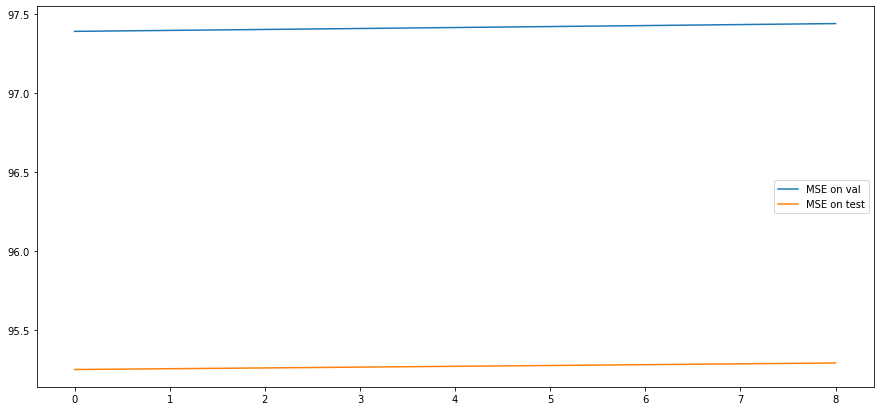

In [194]:
plt.figure(figsize=(15,7))

plt.plot(val_scores, label='MSE on val')
plt.plot(train_scores, label='MSE on test')

plt.legend()
plt.show()

[]

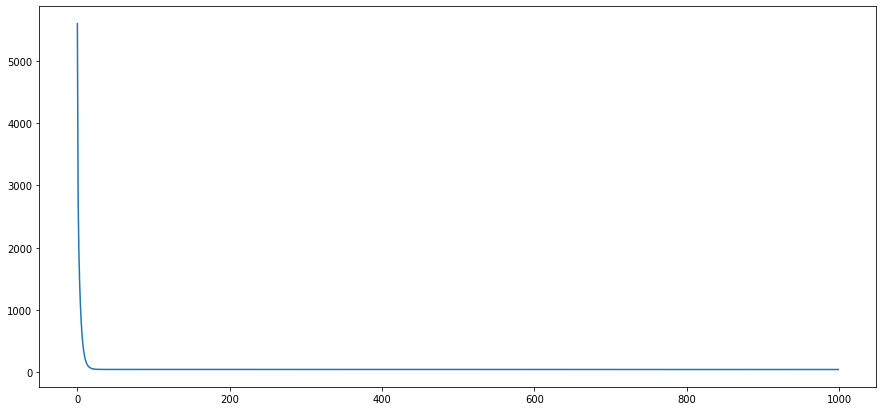

In [199]:
model = LinearRegression(l2_coef=0.01)
model.fit(X_train, y_train)

plt.figure(figsize=(15,7))
plt.plot(model.loss_history)

plt.plot()